In [ ]:
import torch 
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt  
import numpy as np  


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print("Device:", device) 


Device: cuda


In [ ]:
transform = transforms.Compose([  
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])




dataset_path = r'C:\Users\deepa\OneDrive\Desktop\asl_alphabet_train\asl_alphabet_train'

In [ ]:


train_data = datasets.ImageFolder(root=dataset_path, transform=transform)
test_data = datasets.ImageFolder(root=dataset_path, transform=transform)


full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
print("Classes:", full_dataset.classes)


Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
import torch.nn as nn  
import torch.nn.functional as F 

class ASLClassifier(nn.Module):
    def __init__(self):
        super(ASLClassifier, self).__init__()

        # 1st Convolutional Layer: 3 input channels (RGB), 16 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.fc1 = nn.Linear(64 * 8 * 8, 128) 

        self.fc2 = nn.Linear(128, 29)

    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = F.max_pool2d(x, 2, 2)  

        x = F.relu(self.conv2(x))  
        x = F.max_pool2d(x, 2, 2)  

        x = F.relu(self.conv3(x)) 
        x = F.max_pool2d(x, 2, 2) 

        x = x.view(-1, 64 * 8 * 8)  

        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 

        return x


In [7]:
model = ASLClassifier()
print(model)

ASLClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=29, bias=True)
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.99215686].


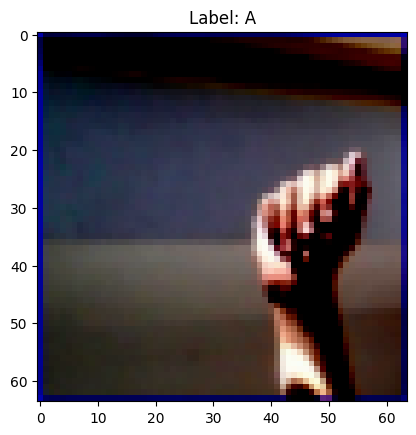

In [19]:
import numpy as np

img, label = full_dataset[3] 

plt.imshow(np.transpose(img, (1, 2, 0)))  
plt.title(f"Label: {full_dataset.classes[label]}")  
plt.show()


In [ ]:
import torch.optim as optim 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

model = ASLClassifier().to(device) 

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)  



In [ ]:
num_epochs = 10  
for epoch in range(num_epochs):  
    model.train()  
    running_loss = 0.0 


    for images, labels in train_loader:  
        images, labels = images.to(device), labels.to(device)  

        optimizer.zero_grad()  

        outputs = model(images) 
        loss = criterion(outputs, labels) 

        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()  

    avg_loss = running_loss / len(train_loader) 
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}") 



torch.save(model.state_dict(), 'asl_classifier.pth')




Epoch [1/10], Loss: 0.6471
Epoch [2/10], Loss: 0.0967
Epoch [3/10], Loss: 0.0574
Epoch [4/10], Loss: 0.0398
Epoch [5/10], Loss: 0.0315
Epoch [6/10], Loss: 0.0281
Epoch [7/10], Loss: 0.0208
Epoch [8/10], Loss: 0.0215
Epoch [9/10], Loss: 0.0202
Epoch [10/10], Loss: 0.0136


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

model.eval()  

all_preds = [] 
all_labels = [] 



In [ ]:
with torch.no_grad():  
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)  

        outputs = model(images) 
        _, predicted = torch.max(outputs, 1) 

        all_preds.extend(predicted.cpu().numpy()) 
        all_labels.extend(labels.cpu().numpy())  


In [ ]:
acc = accuracy_score(all_labels, all_preds)  
prec = precision_score(all_labels, all_preds, average='macro')  
rec = recall_score(all_labels, all_preds, average='macro') 
f1 = f1_score(all_labels, all_preds, average='macro')  

print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'F1-Score: {f1:.4f}')


Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
F1-Score: 0.9993


In [ ]:
cm = confusion_matrix(all_labels, all_preds) 
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[639   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0   0]
 [  0 609   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 598   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 581   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 611   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 609   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 595   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 633   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms

img_path = r'C:\Users\deepa\OneDrive\Desktop\asl_alphabet_train\asl_alphabet_train/A/A1000.jpg'  

img = Image.open(img_path)  

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img = transform(img)  
img = img.unsqueeze(0)  
img = img.to(device) 

model.eval() 

with torch.no_grad():
    output = model(img)
    _, pred = torch.max(output, 1)  
    predicted_class = full_dataset.classes[pred.item()] 

print(f"Predicted Class: {predicted_class}")




Predicted Class: A
